In [1]:
%load_ext autoreload
%autoreload 2

import utils
from visualization.simple_data_vis import histograms
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
from tensorflow import keras
import numpy as np

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(filename)

In [ ]:
# _,_ = histograms(data)

In [3]:
# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
X = data[data.columns[4:]]
y = data[data.columns[2:4]]

# specify train-test split, and batch size (useful for when we do larger datasets)
dataset_size = X.shape[0]
train_size = int(dataset_size * 0.80)

# split data into train and test (this is a generator). consider switching to what Kaylyn did
train_dataset, test_dataset = utils.get_train_and_test_splits(X,y, train_size, batch_size = dataset_size)

In [ ]:
# define Probabilistic Bayesian Neural Network
prob_bnn_model = engine.create_probablistic_bnn_model(
    FEATURE_NAMES = data.columns[4:],
    TARGET_NAMES = data.columns[2:4], 
    train_size = train_size, 
    n_outputs = y.shape[1],
    hidden_units = [16,8,4],
    name = 'PBNN_'+filename
    )

# specify train/test routine 
engine.run_experiment(
    model = prob_bnn_model, 
    loss = negative_loglikelihood, 
    learning_rate = 0.05,
    num_epochs = 400,
    train_dataset = train_dataset, 
    test_dataset = test_dataset
    )

In [15]:
n_samples = 50
sample_inputs, sample_outputs = list(test_dataset.unbatch().shuffle(dataset_size).batch(n_samples))[0]

In [4]:
def model_builder(hp):
    hp_layers = hp.Int('layers', min_value=2, max_value=10)
    hp_units = hp.Int('units', min_value=4, max_value = 32, step=2)
    for L in range(hp_layers):
        hidden_units = [np.ceil(hp_units**(l/L)) for l in range(L)]

    # define Probabilistic Bayesian Neural Network 
    model = engine.create_probablistic_bnn_model(
        FEATURE_NAMES = data.columns[4:],
        TARGET_NAMES = data.columns[2:4], 
        train_size = train_size, 
        n_outputs = y.shape[1],
        hidden_units = hidden_units,
        name = 'PBNN_'+filename
        )

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=engine.negative_loglikelihood,
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model

In [5]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=400,
                     factor=2,
                     directory="surrogate_models/.hypertuning/",
                     project_name='intro_to_kt')

In [6]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 32, 'step': 2, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [7]:
tuner.search(train_dataset, validation_data = test_dataset, epochs = 100)

Trial 642 Complete [00h 00m 15s]
val_loss: 2.5589988231658936

Best val_loss So Far: 0.1679764837026596
Total elapsed time: 02h 11m 52s
INFO:tensorflow:Oracle triggered exit


In [8]:
best = tuner.get_best_models()

In [11]:
best_distributions = best[0](sample_inputs)
best_means = [i.mean().numpy().tolist() for i in best_distributions]


In [12]:
best_means

[[[0.6568162441253662],
  [0.6578735113143921],
  [0.6575702428817749],
  [0.6568752527236938],
  [0.6563711166381836],
  [0.6575285196304321],
  [0.657620906829834],
  [0.6555591821670532],
  [0.6564829349517822],
  [0.6557111740112305]],
 [[0.7004284858703613],
  [0.7068790197372437],
  [0.7051188945770264],
  [0.7008123397827148],
  [0.6974419355392456],
  [0.7048705816268921],
  [0.7054181098937988],
  [0.6915677785873413],
  [0.6982073783874512],
  [0.6927090883255005]]]

In [ ]:
test_pbnn_model = engine.create_probablistic_bnn_model(
    FEATURE_NAMES = data.columns[4:],
    TARGET_NAMES = data.columns[2:4], 
    train_size = train_size, 
    n_outputs = y.shape[1],
    hidden_units = [96,96],
    name = 'test_PBNN_'+filename
    )

# specify train/test routine 
engine.run_experiment(
    model = test_pbnn_model, 
    loss = engine.negative_loglikelihood, 
    learning_rate = 0.001,
    num_epochs = 400,
    train_dataset = train_dataset, 
    test_dataset = test_dataset
    )

Text(0, 0.5, 'predicted')

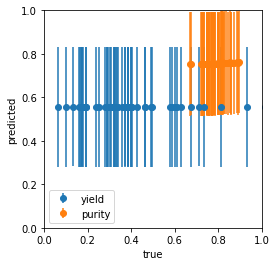

In [23]:
import matplotlib.pyplot as plt
for i,out in enumerate(best[0](sample_inputs)):
    plt.errorbar(sample_outputs[:,i].numpy(), out.mean().numpy().squeeze(),
    yerr = out.stddev().numpy().squeeze(),
    label = data.columns[2:4][i],
    marker = 'o',
    ls = 'none')
plt.legend(loc='lower left')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal')
plt.xlabel('true')
plt.ylabel('predicted')
